In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.feature_selection import mutual_info_classif

In [19]:
import pandas as pd
data = pd.read_csv("data.csv")
data = data.drop(columns=['Unnamed: 0'])

In [ ]:
data.columns

In [ ]:
data = pd.read_csv("data.csv")
X = data.drop(columns=["Label", "Unnamed: 0"])
y = data["Label"]

mi_scores = mutual_info_classif(X, y)

mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print(mi_scores_series)

In [28]:
mi_scores_series=pd.read_csv("Results_of_feature_selection\mi_scores_series.csv")

In [ ]:
mi_scores_series.columns

In [24]:
X = data.drop(columns=["Label"])
y = data["Label"]

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt

def create_autoencoder(input_dim, latent_dim=16):
    input_layer = Input(shape=(input_dim,), name='Input')
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5), name='Encoding')(input_layer)
    latent = Dense(latent_dim, activation='relu', name='Latent')(encoded)
    decoded = Dense(100, activation='relu', name='Decoding')(latent)
    output_layer = Dense(input_dim, activation='linear', name='Output')(decoded)

    autoencoder = Model(input_layer, output_layer)
    return autoencoder

def predict(model, data, threshold):
    reconstructions = model.predict(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return (loss.numpy() < threshold).astype(int)

def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print(f"Accuracy = {accuracy}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 score = {f1}")
    return accuracy, precision, recall, f1




100%|██████████| 1/1 [00:34<00:00, 34.42s/epoch, loss=0.0867, val_loss=0.0749]


4579/4579 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Number of Features: 359
Accuracy = 0.942780704867462
Precision = 0.9997375098433808
Recall = 0.9426096521380448
F1 score = 0.9703334654362226
[[  257     9]
 [ 2087 34278]]


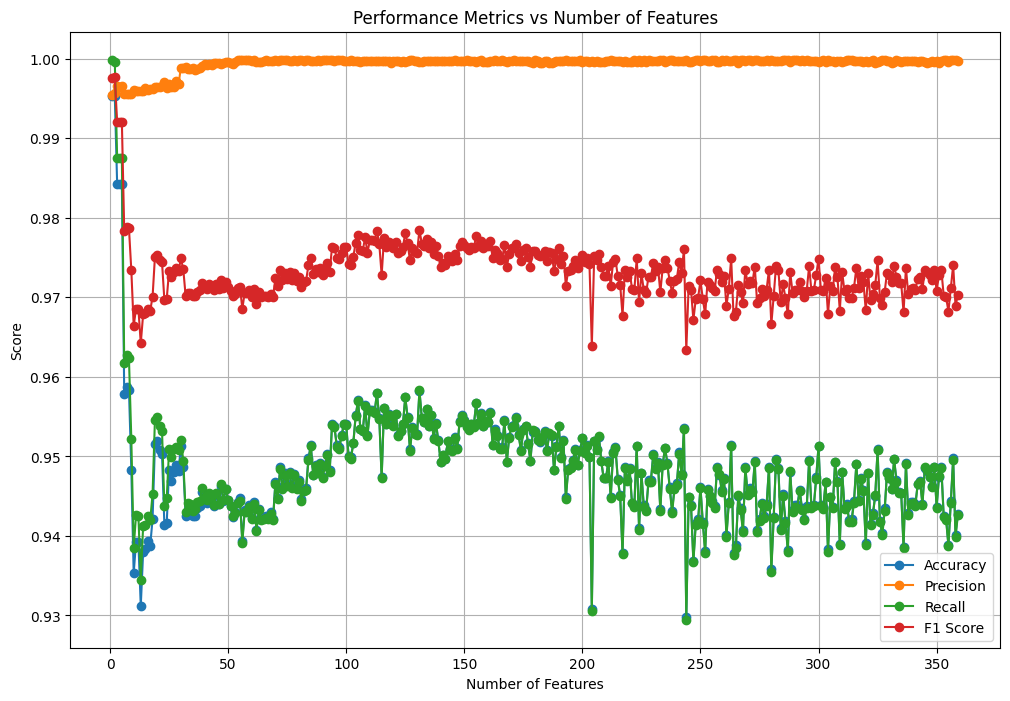

In [30]:
metrics = []
confusion_matrixs = []

for n_features in range(1, X.shape[1] + 1):
    
    selected_features = mi_scores_series["Unnamed: 0"].head(n_features).astype(str).tolist()
    X_selected = X[selected_features]
    print(selected_features)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    autoencoder = create_autoencoder(input_dim=n_features)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    autoencoder.summary()

   
    history = autoencoder.fit(X_train, X_train,
                              batch_size=64, epochs=1, verbose=0, validation_split=0.15,
                              callbacks=[TqdmCallback(), EarlyStopping(patience=3)])


    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
    threshold = np.mean(train_loss) + np.std(train_loss)

    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
    preds = predict(autoencoder, X_test, threshold)
    
    print(f"Number of Features: {n_features}")
    accuracy, precision, recall, f1 = print_stats(preds, y_test)
    
    conf_matrix = confusion_matrix(y_test, preds)
    confusion_matrixs.append({
        "n_feature": confusion_matrix,
        "conf": conf_matrix
    })
    print(conf_matrix)

    metrics.append({
        "n_features": n_features,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    })


metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(
    f"Results_of_feature_selection/feature_selection_metrics2.csv", index=False
)


plt.figure(figsize=(12, 8))
plt.plot(metrics_df["n_features"], metrics_df["accuracy"], marker='o', label="Accuracy")
plt.plot(metrics_df["n_features"], metrics_df["precision"], marker='o', label="Precision")
plt.plot(metrics_df["n_features"], metrics_df["recall"], marker='o', label="Recall")
plt.plot(metrics_df["n_features"], metrics_df["f1_score"], marker='o', label="F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features")
plt.legend()
plt.grid(True)
plt.savefig(f"metrics_vs_features2.png")
plt.show()

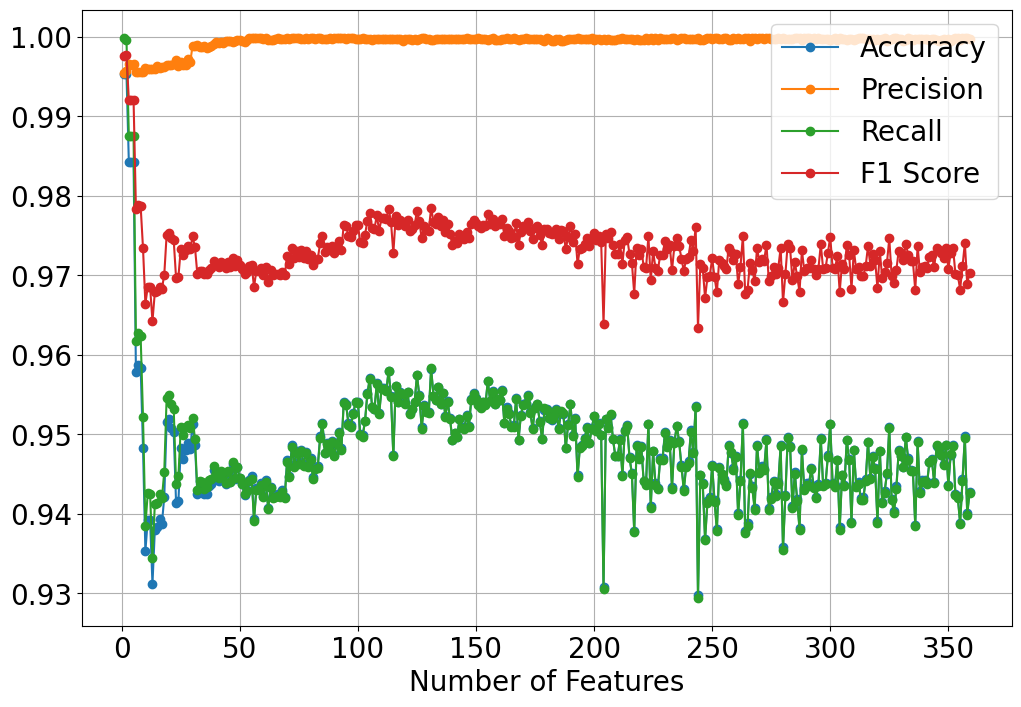

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.read_csv("feature_selection_metrics2.csv")
plt.figure(figsize=(12, 8))

# Plot each metric
plt.plot(metrics_df["n_features"], metrics_df["accuracy"], marker="o", label="Accuracy")
plt.plot(
    metrics_df["n_features"], metrics_df["precision"], marker="o", label="Precision"
)
plt.plot(metrics_df["n_features"], metrics_df["recall"], marker="o", label="Recall")
plt.plot(metrics_df["n_features"], metrics_df["f1_score"], marker="o", label="F1 Score")

# Add labels and legend
plt.xlabel("Number of Features", fontsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Add grid and show the plot
plt.grid(True)
plt.show()

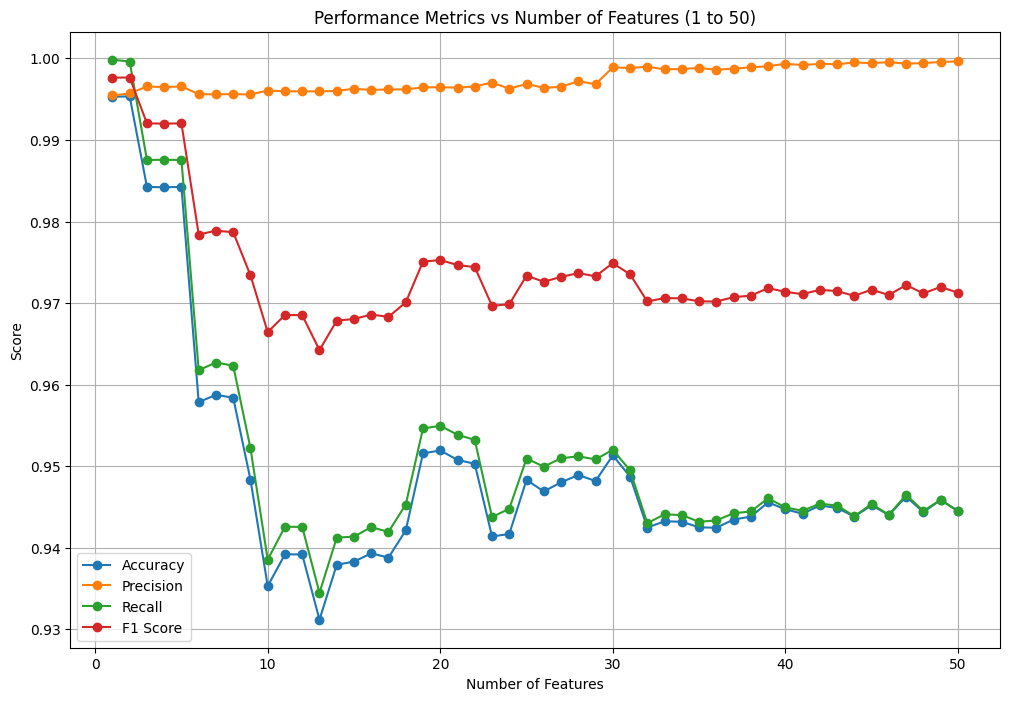

In [31]:
import pandas as pd
import matplotlib.pyplot as plt


filtered_metrics_df = metrics_df[metrics_df["n_features"].between(0, 50)]

plt.figure(figsize=(12, 8))
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["accuracy"],
    marker="o",
    label="Accuracy",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["precision"],
    marker="o",
    label="Precision",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["recall"],
    marker="o",
    label="Recall",
)
plt.plot(
    filtered_metrics_df["n_features"],
    filtered_metrics_df["f1_score"],
    marker="o",
    label="F1 Score",
)
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features (1 to 50)")
plt.legend()
plt.grid(True)
plt.savefig("metrics_vs_features_1_to_50.png")
plt.show()

In [4]:
selected_features = mi_scores_series.head(34).index
X_new = X[selected_features]

In [ ]:
X_new.head

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

metrics = []
confusion_matrixs = []
rf = RandomForestClassifier(n_estimators=100, random_state=42)

for n_features in range(1, X.shape[1] + 1):

    rfe = RFE(estimator=rf, n_features_to_select=n_features)
    X_selected = rfe.fit_transform(X_new, y)
    # Get the selected feature names
    selected_features = X_new.columns[rfe.support_]
    print(selected_features)

    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )

    # Create and compile the autoencoder
    autoencoder = create_autoencoder(input_dim=n_features)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    autoencoder.summary()

    # Fit the model
    history = autoencoder.fit(
        X_train,
        X_train,
        batch_size=64,
        epochs=1,
        verbose=0,
        validation_split=0.15,
        callbacks=[TqdmCallback(), EarlyStopping(patience=3)],
    )

    # Predict reconstruction errors for the training set
    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.keras.losses.mae(reconstructions, X_train).numpy()
    threshold = np.mean(train_loss) + np.std(train_loss)
    print("Threshold: ", threshold)

    # Predict reconstruction errors for the test set
    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.keras.losses.mae(reconstructions, X_test).numpy()
    preds = predict(autoencoder, X_test, threshold)

    # Print and store performance metrics
    print(f"Number of Features: {n_features}")
    accuracy, precision, recall, f1 = print_stats(preds, y_test)

    # Rename the variable to avoid conflict
    conf_matrix = confusion_matrix(y_test, preds)
    print(conf_matrix)
    confusion_matrixs.append({"n_feature": n_features, "conf": conf_matrix})

    # Append metrics
    metrics.append(
        {
            "n_features": n_features,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }
    )

# Convert metrics to DataFrame and save to CSV

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"feature_selection_metrics_rfe_rf.csv", index=False)

# Plot metrics
plt.figure(figsize=(12, 8))
plt.plot(metrics_df["n_features"], metrics_df["accuracy"], marker="o", label="Accuracy")
plt.plot(
    metrics_df["n_features"], metrics_df["precision"], marker="o", label="Precision"
)
plt.plot(metrics_df["n_features"], metrics_df["recall"], marker="o", label="Recall")
plt.plot(metrics_df["n_features"], metrics_df["f1_score"], marker="o", label="F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance Metrics vs Number of Features (RFE with RandomForest)")
plt.legend()
plt.grid(True)
plt.savefig(f"metrics_vs_features_rfe_rf.png")
plt.show()

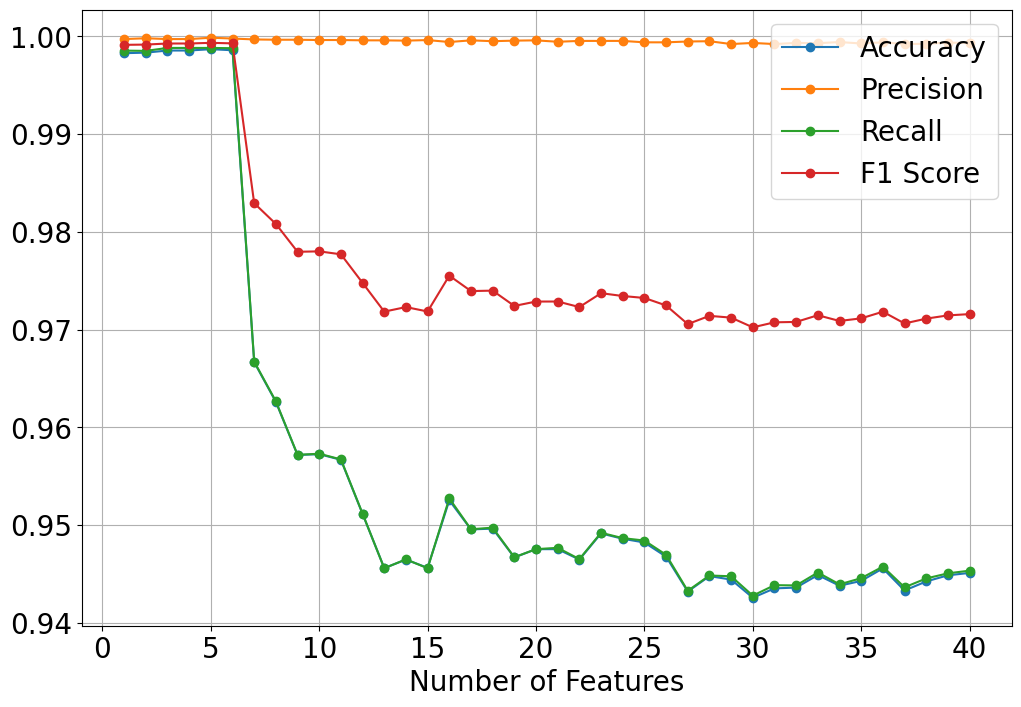

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_df = pd.read_csv("rfe_au.csv")
plt.figure(figsize=(12, 8))

# Plot each metric
plt.plot(metrics_df["n_features"], metrics_df["accuracy"], marker="o", label="Accuracy")
plt.plot(
    metrics_df["n_features"], metrics_df["precision"], marker="o", label="Precision"
)
plt.plot(metrics_df["n_features"], metrics_df["recall"], marker="o", label="Recall")
plt.plot(metrics_df["n_features"], metrics_df["f1_score"], marker="o", label="F1 Score")

# Add labels and legend
plt.xlabel("Number of Features", fontsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# Add grid and show the plot
plt.grid(True)
plt.show()